# Black-Scholes Neural Network Trainer

This notebook generates synthetic European call option data using the Black–Scholes formula, defines a neural network in PyTorch to learn option pricing, trains the model, and visualizes results.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# Black-Scholes Pricing Function (Call or Put)
def bs_price(S, K, T, r, sigma, q, option_type='call'):
    d1 = (torch.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * torch.sqrt(T))
    d2 = d1 - sigma * torch.sqrt(T)
    norm_cdf = lambda x: 0.5 * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))
    
    if option_type == 'call':
        return S * torch.exp(-q * T) * norm_cdf(d1) - K * torch.exp(-r * T) * norm_cdf(d2)
    else:
        return K * torch.exp(-r * T) * norm_cdf(-d2) - S * torch.exp(-q * T) * norm_cdf(-d1)

In [4]:
# Generate synthetic dataset
n_samples = 100_000
S = torch.rand(n_samples) * 100 + 1
K = torch.rand(n_samples) * 100 + 1
T = torch.rand(n_samples) * 2 + 0.01
r = torch.rand(n_samples) * 0.1
sigma = torch.rand(n_samples) * 0.5 + 0.01
q = torch.rand(n_samples) * 0.05

option_type = 'call'  # or 'put'
prices = bs_price(S, K, T, r, sigma, q, option_type)

features = torch.stack([S, K, T, r, sigma, q], dim=1)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features.numpy())
features = torch.tensor(features_scaled, dtype=torch.float32)

In [5]:
dataset = TensorDataset(features, prices.unsqueeze(1))
train_size = int(0.8 * n_samples)
val_size = int(0.2 * n_samples)
test_size = n_samples - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)

In [6]:
# model definition
model = nn.Sequential(
    nn.Linear(6, 10),  # Input layer: 6 inputs → 10 neurons
    nn.ReLU(),
    nn.Linear(10, 10),  # 1st hidden layer
    nn.ReLU(),
    nn.Linear(10, 10),  # 2nd hidden layer
    nn.ReLU(),
    nn.Linear(10, 10),  # 3rd hidden layer
    nn.ReLU(),
    nn.Linear(10, 1)    # Output layer: 1 neuron (regression)
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Training Loop with Validation
epochs = 120
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        val_loss = sum(criterion(model(xb), yb).item() for xb, yb in val_loader) / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

Epoch 1: Train Loss = 58.4287, Val Loss = 1.8846
Epoch 2: Train Loss = 1.2537, Val Loss = 1.0037
Epoch 3: Train Loss = 1.1012, Val Loss = 0.9921
Epoch 4: Train Loss = 0.9961, Val Loss = 0.7343
Epoch 5: Train Loss = 0.8047, Val Loss = 0.7656
Epoch 6: Train Loss = 0.7884, Val Loss = 0.7178
Epoch 7: Train Loss = 0.7888, Val Loss = 0.8126
Epoch 8: Train Loss = 0.7839, Val Loss = 1.4947
Epoch 9: Train Loss = 0.7767, Val Loss = 0.8118
Epoch 10: Train Loss = 0.7659, Val Loss = 0.6958
Epoch 11: Train Loss = 0.6768, Val Loss = 0.5622
Epoch 12: Train Loss = 0.5738, Val Loss = 0.5892
Epoch 13: Train Loss = 0.5483, Val Loss = 0.5348
Epoch 14: Train Loss = 0.5333, Val Loss = 0.5468
Epoch 15: Train Loss = 0.5285, Val Loss = 0.4944
Epoch 16: Train Loss = 0.5249, Val Loss = 0.5233
Epoch 17: Train Loss = 0.5291, Val Loss = 0.7431
Epoch 18: Train Loss = 0.5144, Val Loss = 0.7292
Epoch 19: Train Loss = 0.5229, Val Loss = 0.4651
Epoch 20: Train Loss = 0.5139, Val Loss = 0.4883
Epoch 21: Train Loss = 0.518

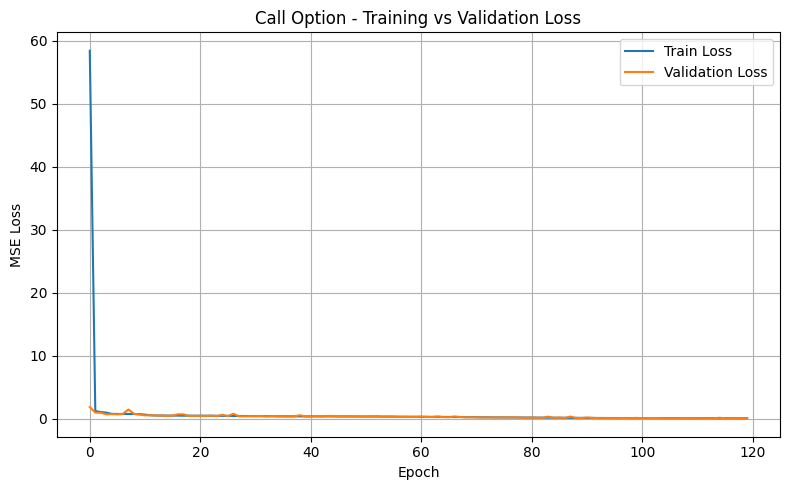

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'{option_type.capitalize()} Option - Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Fixed parameters
K = 120          # Strike price
r = 0.05         # Risk-free rate
sigma = 0.3      # Volatility
T = 0.5          # Time to maturity
q = 0.01          # Dividend yield (assumed zero)
S_values = np.arange(50, 151, 1)

# Generate Black-Scholes prices
PriceBS = [
    bs_price(
        torch.tensor(S_, dtype=torch.float32),
        torch.tensor(K, dtype=torch.float32),
        torch.tensor(T, dtype=torch.float32),
        torch.tensor(r, dtype=torch.float32),
        torch.tensor(sigma, dtype=torch.float32),
        torch.tensor(q, dtype=torch.float32),
        option_type
    ).item()
    for S_ in S_values
]

# Predict using ANN
model.eval()
PriceANN = []

for S_ in S_values:
    input_features = np.array([[S_, K, T, r, sigma, q]])  # shape: (1, 6)
    scaled_input = scaler.transform(input_features)
    input_tensor = torch.tensor(scaled_input, dtype=torch.float32)
    pred_price = model(input_tensor).item()
    PriceANN.append(pred_price)

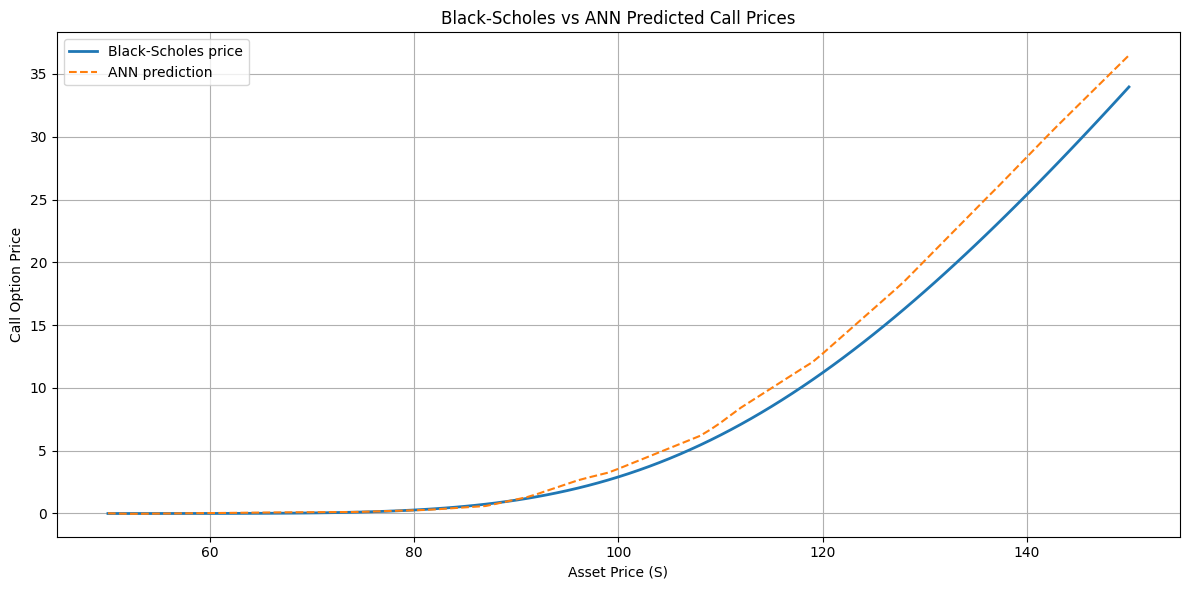

In [10]:
# Plot Black-Scholes vs ANN predictions
plt.figure(figsize=(12, 6))
plt.plot(S_values, PriceBS, label="Black-Scholes price", linewidth=2)
plt.plot(S_values, PriceANN, label="ANN prediction", linestyle='dashed')
plt.xlabel("Asset Price (S)")
plt.ylabel("Call Option Price")
plt.title("Black-Scholes vs ANN Predicted Call Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()